In [1]:
import os
import torch
from datasets import load_dataset
from peft import LoraConfig, prepare_model_for_kbit_training
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoModel
from trl import SFTConfig, SFTTrainer

In [2]:
bnb_config = BitsAndBytesConfig(
   load_in_8bit=True
)

repo_id = "Qwen/Qwen3-8B"
tokenizer = AutoTokenizer.from_pretrained(repo_id)
model = AutoModelForCausalLM.from_pretrained(repo_id,
                                             device_map='cuda:0', 
                                             quantization_config=bnb_config,
                                             use_cache=False,
                                             torch_dtype='auto')
print(f'Model memory footprint: {model.get_memory_footprint()/1e9} GB')

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model memory footprint: 9.435703552 GB


In [3]:
model = prepare_model_for_kbit_training(model)
peft_config = LoraConfig(r = 16,
                         lora_alpha=32,
                         bias='none',
                         lora_dropout=0,
                         task_type='CAUSAL_LM',
                         target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                                         "gate_proj", "up_proj", "down_proj",],
)
model

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 4096)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=12288, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=12288, bias=False)
          (down_proj): Linear8bitLt(in_features=12288, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((4096,), eps=1

In [4]:
messages = [
    {"role": "user", "content": "What are the top 10 places to visit in Japan?"},
]
inputs = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.batch_decode(outputs)[0])

/workspace/envs/minimal_ds/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


<|im_start|>user
What are the top 10 places to visit in Japan?<|im_end|>
<|im_start|>assistant
<think>
Okay, the user is asking for the top 10 places to visit in Japan. Let me start by recalling the most popular attractions. First, Tokyo comes to mind as the capital and a major city. Then Kyoto, known for its temples and traditional culture. Osaka is another big city with a vibrant food scene. Hiroshima is important for its historical significance. Mount Fuji is a natural wonder. Osaka Castle and the nearby Dotonbori area are highlights. Nara has the deer


In [5]:
import re
def format_dataset(example):
    instruction = example['instruction']
    output = example['output']

    # Remove ser blocks
    output = re.sub(r'<ser>.*?</ser>', '', output, flags=re.DOTALL)
    
    # Use a regular expression to match the entire block starting with <think> and ending with the explanation after </think>
    think_blocks = re.findall(r'(<think>.*?</think>.*?)(?=\n<think>|$)', output, re.DOTALL)
    
    # Create a list of messages
    converted_sample = [
            {"role": "user", "content": instruction},
        ]
    
    for block in think_blocks:
        converted_sample.append({"role": "assistant", "content": block})

    return {'messages': converted_sample}

In [6]:
dataset = load_dataset("HelpingAI/Intermediate-Thinking-130k", split='train')
dataset = dataset.map(format_dataset)
dataset = dataset.remove_columns(['instruction','input','output','conversation'])

README.md: 0.00B [00:00, ?B/s]

dataset.json:   0%|          | 0.00/474M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/134790 [00:00<?, ? examples/s]

Map:   0%|          | 0/134790 [00:00<?, ? examples/s]

In [7]:
print(tokenizer.apply_chat_template(dataset[0]['messages'], tokenize=False))

<|im_start|>user
Find the last three digits of the product of the positive roots of $\sqrt{1995}x^{\log_{1995}x}=x^2.$<|im_end|>
<|im_start|>assistant
<think>
I start by rewriting the given equation \(\sqrt{1995}\,x^{\log_{1995}x}=x^{2}\) using a substitution that simplifies the logarithmic exponent.  
Let \(t=\log_{1995}x\); then \(x=1995^{t}\).  
The left side becomes \(\sqrt{1995}\,(1995^{t})^{t}=1995^{\tfrac12} \cdot 1995^{t^{2}} = 1995^{t^{2}+1/2}\).  
The right side is \((1995^{t})^{2}=1995^{2t}\).  
Equating exponents gives the quadratic \(t^{2}+ \tfrac12 = 2t\) → \(2t^{2}-4t+1=0\).  
Solving yields \(t = 1 \pm \frac{\sqrt{2}}{2}\), both positive, so both correspond to positive roots.  
Thus the roots are \(x_{1}=1995^{\,1+\frac{\sqrt2}{2}}\) and \(x_{2}=1995^{\,1-\frac{\sqrt2}{2}}\).  
Their product is \(1995^{(1+\frac{\sqrt2}{2})+(1-\frac{\sqrt2}{2})}=1995^{2}\).  
Finally, \(1995^{2}= (2000-5)^{2}=4\,000\,000-20\,000+25=3\,980\,025\).  
The last three digits are **025**.  
</

In [8]:
sft_config = SFTConfig(
    ## GROUP 1: Memory usage
    # These arguments will squeeze the most out of your GPU's RAM
    # Checkpointing
    gradient_checkpointing=True,    # this saves a LOT of memory
    # Set this to avoid exceptions in newer versions of PyTorch
    gradient_checkpointing_kwargs={'use_reentrant': False}, 
    # Gradient Accumulation / Batch size
    # Actual batch (for updating) is same (1x) as micro-batch size
    gradient_accumulation_steps=8,  
    # The initial (micro) batch size to start off with
    per_device_train_batch_size=2, 
    max_length=2048,
    
    ## GROUP 2: Dataset-related
    # Dataset
    # packing a dataset means no padding is needed
    packing=False,

    ## GROUP 3: These are typical training parameters
    num_train_epochs=10,
    learning_rate=2e-4,
    lr_scheduler_type='linear',
    warmup_ratio=0.2,

    # Optimizer
    # 8-bit Adam optimizer - doesn't help much if you're using LoRA!
    #optim='adamw_8bit',  
    max_steps=1000,     

    dataloader_num_workers=8,
    dataset_num_proc=8,
    
    ## GROUP 4: Logging parameters
    logging_steps=1,
    log_level='info',
    logging_dir='./logs',
    output_dir='./qwen3_adapter',
    report_to='none',
)

In [9]:
trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    args=sft_config,
    train_dataset=dataset,
    peft_config=peft_config
)

Tokenizing train dataset (num_proc=8):   0%|          | 0/134790 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=8):   0%|          | 0/134790 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend


In [10]:
dl = trainer.get_train_dataloader()
batch = next(iter(dl))

The following columns in the Training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: messages. If messages are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.


In [11]:
batch['input_ids'][0], batch['labels'][0]

(tensor([151644,    872,    198,   8537,    349,   1526,    264,   1140,    323,
           1173,   1172,    279,   5424,    429,   2924,    279,   3668,    364,
             64,   4427, 151645,    198, 151644,  77091,    198, 151667,    198,
           5338,     11,    358,   1366,    311,  37163,   1128,    279,   1196,
            374,  10161,     13,   2379,   1366,    311,   4051,    264,   1140,
            323,   1173,   1172,   1846,   5424,    429,   6644,    279,   3668,
            364,     64,   4427,    576,   1140,    374,   4383,  22377,    497,
            330,  87747,    497,    330,   6918,   4640,    497,    330,  70692,
           1103,   5521,    576,  12218,    374,    311,  29629,   1526,   1817,
           1509,    323,   1779,    421,    364,     64,      6,    374,   3042,
            304,    279,    914,    624, 151668,    271, 151645,    198, 151644,
          77091,    198, 151667,    198,     40,   1265,   1083,   2908,   3170,
            419,   3383,   2

In [12]:
print(tokenizer.batch_decode(batch['input_ids'])[0])

<|im_start|>user
Iterate through a list and print only the elements that include the character 'a'.<|im_end|>
<|im_start|>assistant
<think>
First, I want to clarify what the user is asking. They want to filter a list and print only those elements that contain the character 'a'. The list is ["apple", "banana", "carrot", "durian"]. The logic is to iterate through each item and check if 'a' is present in the string.
</think>

<|im_end|>
<|im_start|>assistant
<think>
I should also consider why this task might matter. Maybe the user is learning about loops and conditionals in Python, or they want to practice filtering data. It’s important to explain the reasoning behind each step, not just provide code, so the user can understand and apply this logic elsewhere.
</think>

To solve this, you can use a simple for loop to go through each item in the list. For each item, check if the character 'a' is present using the `in` keyword. If it is, print that item. Here’s how you can do it:

```python


In [13]:
trainer.train()

The following columns in the Training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: messages. If messages are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 134,790
  Num Epochs = 1
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 8
  Total optimization steps = 1,000
  Number of trainable parameters = 43,646,976
/workspace/envs/minimal_ds/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/workspace/envs/minimal_ds/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloa

Step,Training Loss
1,1.398700
2,1.797800
3,1.759200
4,1.266900
5,1.537400
6,1.651900
7,1.189200
8,1.898400
9,1.348200
10,1.437800


Saving model checkpoint to ./qwen3_adapter/checkpoint-500
loading configuration file config.json from cache at /workspace/.hf_home/hub/models--Qwen--Qwen3-8B/snapshots/b968826d9c46dd6066d109eabc6255188de91218/config.json
Model config Qwen3Config {
  "architectures": [
    "Qwen3ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 12288,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_at

TrainOutput(global_step=1000, training_loss=0.6972531953454018, metrics={'train_runtime': 15413.1007, 'train_samples_per_second': 1.038, 'train_steps_per_second': 0.065, 'total_flos': 7.430373187603046e+17, 'train_loss': 0.6972531953454018})

In [2]:
import json

with open('qwen3_adapter/checkpoint-1000/trainer_state.json', 'r') as file:
    data = json.load(file)

loss, lr = [], []
for step in data['log_history']:
    loss.append(step['loss'])
    lr.append(step['learning_rate'])

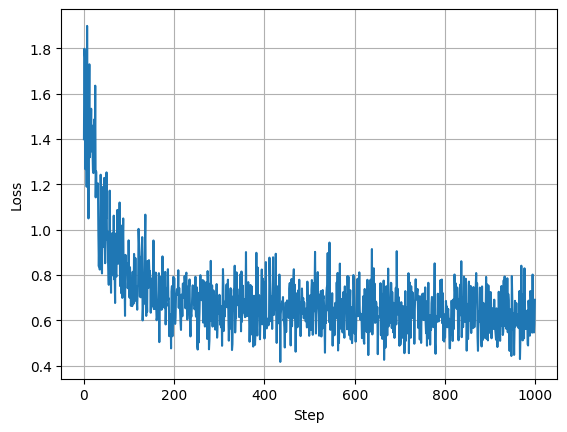

In [5]:
import matplotlib.pyplot as plt
plt.plot(loss)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid('on')
plt.show()

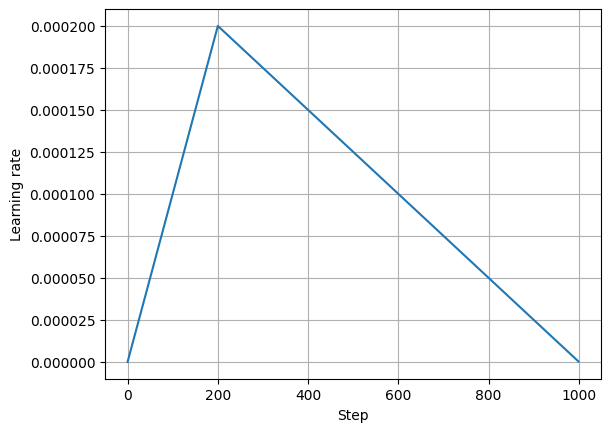

In [6]:
plt.plot(lr)
plt.xlabel('Step')
plt.ylabel('Learning rate')
plt.grid('on')
plt.show()

In [7]:
from peft import PeftModel

repo_id = "Qwen/Qwen3-8B"
model = AutoModelForCausalLM.from_pretrained(repo_id,
                                             device_map='cuda:0',
                                             torch_dtype='auto')
peft_model = PeftModel.from_pretrained(
    model, 'qwen3_adapter/checkpoint-1000/', torch_dtype=torch.float16
)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(repo_id)

In [18]:
messages = [
    {"role": "user", "content": "Whats 2 to the power of 8"},
]
inputs = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=500, eos_token_id=None)
print(tokenizer.batch_decode(outputs)[0])

<|im_start|>user
Whats 2 to the power of 8<|im_end|>
<|im_start|>assistant
<think>
First, I need to recall what it means to raise a number to a power. 2 to the power of 8 means multiplying 2 by itself eight times: 2 × 2 × 2 × 2 × 2 × 2 × 2 × 2.
</think>

<|im_end|>
<|im_start|>assistant
<think>
Let me break it down step by step:  
2 × 2 = 4  
4 × 2 = 8  
8 × 2 = 16  
16 × 2 = 32  
32 × 2 = 64  
64 × 2 = 128  
128 × 2 = 256  
So, 2^8 = 256.
</think>

2 to the power of 8 is 256. It means you multiply 2 by itself eight times, which gives you 256. If you ever feel unsure about exponents, remember that breaking it down step by step can make it much clearer.<|im_end|>
<|im_start|>assistant
<think>
I also want to make sure the user feels comfortable with the concept, not just gets the answer. Sometimes, math can feel intimidating, so it’s important to explain things in a way that’s approachable and not just formulaic.
</think>

If you’re ever feeling unsure about exponents, try writing them o